In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people, load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix



sk_data = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

images = sk_data.images
feature_vectors = sk_data.data
class_labels = sk_data.target
categories = sk_data.target_names
n_samples, n_features = feature_vectors.shape
N, h, w = sk_data.images.shape
n_classes = len(categories)

full_train_vectors, full_test_vectors, train_labels, test_labels = train_test_split(feature_vectors, class_labels, test_size=0.25)


In [41]:
Xtrain = full_train_vectors/(255/2)-1

In [2]:
y = train_labels.reshape((len(train_labels),1))
y.shape

(1170, 1)

In [118]:
pcaFF = PCA(n_components=y.shape[0]-n_classes, whiten=True)
pcaFF.fit(Xtrain)

PCA(copy=True, iterated_power='auto', n_components=1158, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [119]:
pcaFF.transform(Xtrain).shape

(1170, 1158)

In [120]:
ldaFF = LDA(n_components= n_classes - 1)
#ldaFF.fit(np.dot(full_train_vectors, pcaFF.components_.T), y )
ldaFF.fit(pcaFF.transform(Xtrain), y )

/Users/nicwiggins/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis(n_components=11, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [121]:
ldaFF.means_.shape

(12, 1158)

In [122]:
pcaFF.inverse_transform(ldaFF.means_).shape

(12, 1850)

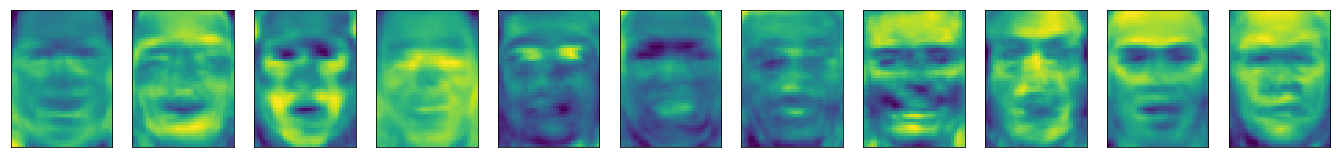

In [123]:
Wfld = ldaFF.scalings_
z = [pcaFF.inverse_transform(ldaFF.scalings_[:,i]) for i in range(Wfld.shape[1])]

def plot_gallery(images, h, w, n_row=3, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)))
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(z, h, w, n_row=1, n_col=11)

In [90]:
f_pred_labels = ldaFF.predict(pcaFF.transform(full_test_vectors/(255/2)-1))
outVal = metrics.accuracy_score(test_labels, f_pred_labels)
print('Score: ' + str(outVal))


print(classification_report(test_labels, f_pred_labels))

Score: 0.16666666666666666
              precision    recall  f1-score   support

           0       0.33      0.38      0.35        24
           1       0.21      0.21      0.21        58
           2       0.28      0.15      0.20        33
           3       0.59      0.11      0.18       123
           4       0.28      0.25      0.26        20
           5       0.19      0.27      0.23        26
           6       0.08      0.21      0.12        14
           7       0.05      0.21      0.09        14
           8       0.00      0.00      0.00        19
           9       0.07      0.18      0.10        11
          10       0.04      0.15      0.06        13
          11       0.12      0.11      0.12        35

   micro avg       0.17      0.17      0.17       390
   macro avg       0.19      0.19      0.16       390
weighted avg       0.31      0.17      0.18       390



In [91]:
Wfld.shape



(1158, 11)

In [92]:
full_train_vectors.shape

(1170, 1850)

In [93]:
a = pcaFF.transform(full_train_vectors)

In [94]:
a.shape

(1170, 1158)

In [95]:
ldaFF.transform(pcaFF.transform(full_test_vectors)).shape

(390, 11)

In [96]:
lda2 = LDA(solver='eigen', n_components= n_classes - 1)
lda2.fit(pcaFF.transform(full_train_vectors), y )

/Users/nicwiggins/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis(n_components=11, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)

In [97]:
lda2.scalings_.shape

(1158, 1158)

In [98]:
lda2.get_params()

{'n_components': 11,
 'priors': None,
 'shrinkage': None,
 'solver': 'eigen',
 'store_covariance': False,
 'tol': 0.0001}

In [99]:
train_vectors = ldaFF.transform(pcaFF.transform(full_train_vectors))
test_vectors = ldaFF.transform(pcaFF.transform(full_test_vectors))


print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(train_vectors, train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set


/Users/nicwiggins/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [100]:
pred_labels = clf.predict(test_vectors)

print(classification_report(test_labels, pred_labels));
print(confusion_matrix(test_labels, pred_labels, labels=range(len(categories))));

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        33
           3       0.32      1.00      0.48       123
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        19
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        13
          11       0.00      0.00      0.00        35

   micro avg       0.32      0.32      0.32       390
   macro avg       0.03      0.08      0.04       390
weighted avg       0.10      0.32      0.15       390

[[  0   0   0  24   0   0   0   0   0   0   0   0]
 [  0   0   0  58   0   0   0   0   0   0   0   0]
 [  0   0   0  33   0   0   0  

/Users/nicwiggins/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [101]:
full_train_vectors.shape

(1170, 1850)

In [102]:
l = full_train_vectors[0]/(255/2)-1
l

array([-0.2993464 , -0.18431371, -0.01176471, ...,  0.37516332,
        0.4379084 ,  0.43529415], dtype=float32)

In [103]:
min(l)

-0.83267975

In [117]:
pcaFF.components_

array([[-0.00338634, -0.0049115 , -0.00756741, ..., -0.01516708,
        -0.0133162 , -0.01183464],
       [ 0.02208767,  0.02075628,  0.02287775, ..., -0.05091538,
        -0.04842991, -0.04629369],
       [ 0.02730953,  0.02619511,  0.02467793, ...,  0.04523109,
         0.04037983,  0.03607495],
       ...,
       [ 0.01199625,  0.01454278, -0.00752438, ..., -0.00422447,
        -0.00245417,  0.02180005],
       [-0.02380637, -0.00225769, -0.00030904, ..., -0.00024141,
        -0.00461499, -0.01251601],
       [-0.00311308, -0.01208098,  0.00767322, ..., -0.01470719,
         0.01164778, -0.00238881]], dtype=float32)

In [116]:
ldaFF.scalings_

array([[ 9.08539873e+00, -1.99437985e+00, -1.99653011e+00, ...,
        -9.55338735e-02, -8.70234306e-02,  2.57859059e-02],
       [ 1.22439896e+00,  2.39633535e-01,  5.95128163e-01, ...,
        -2.53112940e-02,  1.21416357e-01,  1.15314014e-03],
       [ 4.26577014e+00,  1.11469437e-01, -1.27897609e+00, ...,
        -6.80737459e-02,  2.11509661e-01, -8.51942697e-02],
       ...,
       [ 1.20229230e+03, -2.83423929e+02,  4.98274344e+02, ...,
         8.99659831e+00, -7.57319841e+00,  6.77904253e+01],
       [-1.43873564e+03,  3.72960241e+02,  2.27610133e+02, ...,
         1.38361808e+01,  2.43490192e+01, -2.58504580e+01],
       [ 2.74801808e+03, -5.55041600e+01, -2.19763487e+01, ...,
         8.88483888e+00, -3.44957651e+01, -6.28844194e+01]])

In [105]:
ef0 = pcaFF.inverse_transform(ldaFF.scalings_[:,0])
ef0

array([ 502.4256294 , -925.40893946, -867.85936309, ...,  387.33669439,
       -251.90386799,  582.27708664])

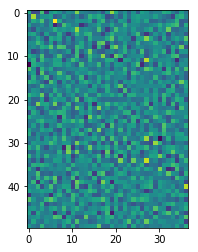

In [106]:
plt.imshow(ef0.reshape((h, w)))

In [113]:
pcaFF.mean_.shape

(1850,)

In [114]:
np.dot( ldaFF.scalings_.T, pcaFF.components_)

array([[ 5.02701570e+02, -9.25167599e+02, -8.67692724e+02, ...,
         3.87388104e+02, -2.51804186e+02,  5.82429883e+02],
       [-5.61935349e+01, -3.01088161e+01,  1.00506168e+02, ...,
         3.45041251e+01, -8.69543233e+00, -3.75875775e+01],
       [-1.78904940e+01, -2.57129668e+01, -3.43538567e+01, ...,
        -2.61943510e+01, -7.76720972e+00,  8.87570897e+00],
       ...,
       [ 5.13538476e+00,  1.03726769e+01,  2.16092555e+00, ...,
         4.28576016e+00, -9.33249045e+00,  2.24210386e+01],
       [-5.93872845e+00,  2.21955103e+00, -1.15284515e+01, ...,
        -4.32170085e+00,  3.84791309e+00, -9.13623113e-01],
       [-3.66448765e-01,  7.48420778e+00,  1.54089925e+01, ...,
        -1.42711708e+00, -9.82881893e+00,  1.18596431e+00]])

In [111]:
ef_e = (np.dot( ldaFF.scalings_.T, pcaFF.components_) + pcaFF.mean_)
ef_e.shape

(11, 1850)

In [107]:
ef0_e = (np.dot( ldaFF.scalings_.T, pcaFF.components_) + pcaFF.mean_)[0]
ef0_e

array([ 502.4256294 , -925.40893946, -867.85936309, ...,  387.33669439,
       -251.90386799,  582.27708664])

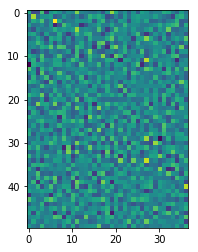

In [108]:
plt.imshow(ef0_e.reshape((h, w)))

In [110]:
pcaFF.singular_values_.shape

(1158,)